- Libraries used in this assignment:

In [88]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# 1. Data Preprocessing Steps

# 1.1. Dataset Cleaning

The dataset was cleaned by addressing missing values, standardizing numerical features, and encoding categorical data. This ensures consistency and prepares the data for accurate model training.

In [89]:
df = pd.read_csv("C:/Users/asus/OneDrive/Desktop/Second Assignment ML/archive/cars.csv") 
df   

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa
...,...,...,...,...,...,...,...,...,...
6303,Bentley Mulsanne 2021 6.75L V8 Extended Wheelbase,DISCONTINUED,6.8,8,505,296,5 Seater,bentley,uae
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,"AED 1,766,100",4.0,8,25,800,Automatic,ferrari,uae
6305,Rolls Royce Wraith 2021 6.6L Base,"AED 1,400,000",6.6,12,624,250,4 Seater,rolls-royce,uae
6306,Lamborghini Aventador S 2021 6.5L V12 Coupe,"AED 1,650,000",6.5,NaN,740,350,2 Seater,lamborghini,uae


# 1.1.1. Data Types Conversion and Data Inconsistency

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


Since all the features are currently of type object, but many contain floating-point values, we will convert them to numerical data types to facilitate statistical analysis and other evaluations.

In [91]:
for column in df.select_dtypes(include='object'):
    print(f"{column}: {df[column].unique()}")

car name: ['Fiat 500e 2021 La Prima' 'Peugeot Traveller 2021 L3 VIP'
 'Suzuki Jimny 2021 1.5L Automatic' ...
 'BMW M8 Convertible 2021 4.4T V8 Competition xDrive (625 Hp)'
 'BMW M8 Coupe 2021 4.4T V8 Competition xDrive (625 Hp)'
 'Lamborghini Aventador Ultimae 2022 LP 780-4']
price: ['TBD' 'SAR 140,575' 'SAR 98,785' ... 'AED 1,990,000' 'AED 1,766,100'
 'AED 1,650,000']
engine_capacity: ['0.0' '2.0' '1.5' '2.3' '1.8' '2.5' '2.7' '5.2' '4.0' '3.5' '3.8' '1.6'
 '3.0' '6.2' '3.7' '6.5' '1.7' '1.4' '2.2' '2.4' '5.0' '6.7' '4.4' '5.7'
 '3.6' '1.2' '3.3' '2.9' '2.8' '6.0' '3.9' '1.3' '1.0' '3.2' '5.3' '4.5'
 '4.8' '6.4' '4.6' '5.6' '4.7' '5.5' '8.0' '6.3' '6.6' '5.9' '6.8' '2359'
 '1600' '1498' '5200' '3982' '1991' '1598' 'Cylinders' '1500' '1800'
 '1497' '2500' '1969' '2000' '1400' '4395' '1984' '1591' '2998' '2995'
 '1988' '2497' '1300' '1499' '3995' '1489' '1998' '1490' '2891' '1995'
 '4400' '1197' '1200' '1199' '1561' '1332' '3000' '1798' '1997' '1000'
 '1590' '1396' '1248' '1485' '999' '

- price: Contains non-numeric entries like TBD. Hence, it requires cleaning to convert numeric values and handle non-numeric entries.
- engine_capacity, cylinder, horse_power, top_speed, seats: Mixed with numeric values and non-numeric entries (e.g., N/A, Electric, Drive Type, Automatic). Non-numeric entries should be handled to maintain numeric consistency.
- brand and country: These are categorical and don't need conversion, but ensure consistency (e.g., lowercase).

The brand column contains a variety of unique car brands, and most of the values look clean and consistent. However, 'soueast ' (with a trailing space) and 'soueast' appear to be duplicates caused by inconsistent formatting.

In [92]:
string_columns = df.select_dtypes(include=['object']).columns

df[string_columns] = df[string_columns].apply(lambda x: x.str.strip())

We extract the year from the car name feature:

In [93]:
df['car_year'] = df['car name'].str.extract(r'(\b\d{4}\b)')

# Convert car_year to integer
df['car_year'] = pd.to_numeric(df['car_year'], errors='coerce').astype('Int64')

# 1) Cleaning Price Feature

In [94]:
df['price'].value_counts()

price
TBD               437
Following         238
DISCONTINUED      140
Follow             27
Grigio Maratea     23
                 ... 
SAR 73,485          1
SAR 374,000         1
SAR 1,043,477       1
SAR 179,314         1
SAR 1,386,462       1
Name: count, Length: 3395, dtype: int64

Standardize all prices to a common currency USD:

In [95]:
# Define exchange rates
exchange_rates = {
    'SAR': 0.2666,
    'BHD': 2.6596,
    'AED': 0.2723,
    'KWD': 3.1085,
    'OMR': 2.46,
    'QAR': 0.26,
    'EGP': 0.0195
}

# Function to extract currency and amount
def extract_currency_amount(price):
    match = re.match(r'([A-Z]{3})\s*([\d,]+)', price)
    if match:
        currency = match.group(1)
        amount = float(match.group(2).replace(',', ''))
        return currency, amount
    else:
        return None, None

# Apply extraction and conversion
def convert_to_usd(price):
    if pd.isna(price) or price in ['TBD', 'Following', 'DISCONTINUED']:
        return np.nan
    currency, amount = extract_currency_amount(price)
    if currency and amount and currency in exchange_rates:
        return amount * exchange_rates[currency]
    else:
        return np.nan

# Create a new column with prices in USD
df['price_usd'] = df['price'].apply(convert_to_usd)

df[['price', 'price_usd']]

,price,price_usd
0,TBD,NaN
1,"SAR 140,575",37477.295
2,"SAR 98,785",26336.081
3,"SAR 198,000",52786.800
4,Orangeburst Metallic,NaN
...,...,...
6303,DISCONTINUED,NaN
6304,"AED 1,766,100",480909.030
6305,"AED 1,400,000",381220.000
6306,"AED 1,650,000",449295.000


In [96]:
columns_to_clean = ['engine_capacity', 'horse_power', 'top_speed', 'cylinder', 'seats']
for column in columns_to_clean:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Clean 'price' column 
df['price_usd'] = df['price'].apply(convert_to_usd)

# Clean categorical columns
df['brand'] = df['brand'].str.lower()
df['country'] = df['country'].str.lower()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car name         6308 non-null   object 
 1   price            6308 non-null   object 
 2   engine_capacity  6305 non-null   float64
 3   cylinder         5574 non-null   float64
 4   horse_power      6186 non-null   float64
 5   top_speed        5875 non-null   float64
 6   seats            403 non-null    float64
 7   brand            6308 non-null   object 
 8   country          6308 non-null   object 
 9   car_year         6308 non-null   Int64  
 10  price_usd        4979 non-null   float64
dtypes: Int64(1), float64(6), object(4)
memory usage: 548.4+ KB


# 2) Cleaning Engine Capacity Feature

In [97]:
df['engine_capacity'].value_counts()

engine_capacity
2.0       1241
3.0        703
3.5        359
1.5        347
4.0        340
          ... 
3993.0       1
5935.0       1
1.9          1
6752.0       1
3400.0       1
Name: count, Length: 128, dtype: int64

To clean the engine_capacity feature where some values are in liters and others in cubic meters (𝑚^3), we can standardize all the values to a single unit, such as liters. Since 1𝑚^3=1000 liters, we will multiply any values identified in 𝑚^3 by 1000.

In [98]:
# Identify potential values in m^3 (assume values <= 20 are in liters, others in m^3)
df['engine_capacity_cleaned'] = df['engine_capacity'].apply(
    lambda x: x / 1000 if x > 20 else x
)

df['engine_capacity_cleaned'].value_counts()

engine_capacity_cleaned
2.000    1251
3.000     711
1.600     387
1.500     365
3.500     359
         ... 
5.935       1
5.950       1
6.752       1
2.981       1
1.900       1
Name: count, Length: 110, dtype: int64

In [99]:
df['engine_capacity_cleaned'].unique()

array([0.   , 2.   , 1.5  , 2.3  , 1.8  , 2.5  , 2.7  , 5.2  , 4.   ,
       3.5  , 3.8  , 1.6  , 3.   , 6.2  , 3.7  , 6.5  , 1.7  , 1.4  ,
       2.2  , 2.4  , 5.   , 6.7  , 4.4  , 5.7  , 3.6  , 1.2  , 3.3  ,
       2.9  , 2.8  , 6.   , 3.9  , 1.3  , 1.   , 3.2  , 5.3  , 4.5  ,
       4.8  , 6.4  , 4.6  , 5.6  , 4.7  , 5.5  , 8.   , 6.3  , 6.6  ,
       5.9  , 6.8  , 2.359, 1.498, 3.982, 1.991, 1.598,   nan, 1.497,
       1.969, 4.395, 1.984, 1.591, 2.998, 2.995, 1.988, 2.497, 1.499,
       3.995, 1.489, 1.998, 1.49 , 2.891, 1.995, 1.197, 1.199, 1.561,
       1.332, 1.798, 1.997, 1.59 , 1.396, 1.248, 1.485, 0.999, 1.395,
       1.587, 1.368, 1.586, 1.299, 1.597, 1.496, 0.14 , 2.693, 3.342,
       2.476, 1.595, 3.498, 3.47 , 3.828, 2.987, 2.979, 4.999, 5.935,
       4.691, 3.993, 5.95 , 2.894, 2.981, 6.752, 3.4  , 3.996, 1.9  ,
       4.2  , 2.1  , 4.1  ])

In [100]:
df['engine_capacity_cleaned'].describe()

count    6305.000000
mean        2.815384
std         1.365533
min         0.000000
25%         2.000000
50%         2.500000
75%         3.600000
max         8.000000
Name: engine_capacity_cleaned, dtype: float64

# 1.1.2. Handling Mixed-Up Values

- horse_power: Typical range for cars might be 50 to 1500.
- top_speed: Typical range is 100 to 400 km/h.
- seats: Typical range is 2 to 8.

For each column, we checked if the value is outside its valid range, If a value is valid for another column, we moved it there.

In [101]:
# Define valid ranges for each feature
horse_power_range = (50, 2000)  # Typical range for horsepower
top_speed_range = (100, 400)    # Typical range for top speed in km/h
seats_range = (2, 8)            # Typical range for the number of seats

# Function to fix mixed-up values
def fix_mixed_values(row):
    # If a value in horse_power is out of range, check where it might belong
    if not horse_power_range[0] <= row['horse_power'] <= horse_power_range[1]:
        if top_speed_range[0] <= row['horse_power'] <= top_speed_range[1]:
            row['top_speed'] = row['horse_power']  # Move to top_speed
            row['horse_power'] = np.nan           # Set horse_power to NaN
        elif seats_range[0] <= row['horse_power'] <= seats_range[1]:
            row['seats'] = row['horse_power']     # Move to seats
            row['horse_power'] = np.nan           # Set horse_power to NaN

    # If a value in top_speed is out of range, check where it might belong
    if not top_speed_range[0] <= row['top_speed'] <= top_speed_range[1]:
        if horse_power_range[0] <= row['top_speed'] <= horse_power_range[1]:
            row['horse_power'] = row['top_speed'] # Move to horse_power
            row['top_speed'] = np.nan             # Set top_speed to NaN
        elif seats_range[0] <= row['top_speed'] <= seats_range[1]:
            row['seats'] = row['top_speed']       # Move to seats
            row['top_speed'] = np.nan             # Set top_speed to NaN

    # If a value in seats is out of range, handle it
    if not seats_range[0] <= row['seats'] <= seats_range[1]:
        if horse_power_range[0] <= row['seats'] <= horse_power_range[1]:
            row['horse_power'] = row['seats']     # Move to horse_power
            row['seats'] = np.nan                 # Set seats to NaN
        elif top_speed_range[0] <= row['seats'] <= top_speed_range[1]:
            row['top_speed'] = row['seats']       # Move to top_speed
            row['seats'] = np.nan                 # Set seats to NaN
        else:
            row['seats'] = np.nan                 # Set invalid seats values to NaN

    return row

# Apply the function to clean the dataset
df = df.apply(fix_mixed_values, axis=1)   

# Print unique values for float columns after cleaning
for column in df.select_dtypes(include='float'):
    print(f"{column}: {df[column].unique()}")

engine_capacity: [0.000e+00 2.000e+00 1.500e+00 2.300e+00 1.800e+00 2.500e+00 2.700e+00
 5.200e+00 4.000e+00 3.500e+00 3.800e+00 1.600e+00 3.000e+00 6.200e+00
 3.700e+00 6.500e+00 1.700e+00 1.400e+00 2.200e+00 2.400e+00 5.000e+00
 6.700e+00 4.400e+00 5.700e+00 3.600e+00 1.200e+00 3.300e+00 2.900e+00
 2.800e+00 6.000e+00 3.900e+00 1.300e+00 1.000e+00 3.200e+00 5.300e+00
 4.500e+00 4.800e+00 6.400e+00 4.600e+00 5.600e+00 4.700e+00 5.500e+00
 8.000e+00 6.300e+00 6.600e+00 5.900e+00 6.800e+00 2.359e+03 1.600e+03
 1.498e+03 5.200e+03 3.982e+03 1.991e+03 1.598e+03       nan 1.500e+03
 1.800e+03 1.497e+03 2.500e+03 1.969e+03 2.000e+03 1.400e+03 4.395e+03
 1.984e+03 1.591e+03 2.998e+03 2.995e+03 1.988e+03 2.497e+03 1.300e+03
 1.499e+03 3.995e+03 1.489e+03 1.998e+03 1.490e+03 2.891e+03 1.995e+03
 4.400e+03 1.197e+03 1.200e+03 1.199e+03 1.561e+03 1.332e+03 3.000e+03
 1.798e+03 1.997e+03 1.000e+03 1.590e+03 1.396e+03 1.248e+03 1.485e+03
 9.990e+02 1.395e+03 1.587e+03 1.368e+03 1.586e+03 1.299e+03

# 1.1.3. Handling Missing Values & Final Changes on the Data Types

In [102]:
df.isna().sum()

car name                      0
price                         0
engine_capacity               3
cylinder                    734
horse_power                  43
top_speed                   441
seats                      6100
brand                         0
country                       0
car_year                      0
price_usd                  1329
engine_capacity_cleaned       3
dtype: int64

# I. Filling missing values in engine_capacity feature:

In [103]:
# Group by 'brand' and calculate the mean engine capacity for each group
df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], errors='coerce')
grouped_means = df.groupby('brand')['engine_capacity'].transform('mean')

df['engine_capacity_cleaned'] = pd.to_numeric(df['engine_capacity_cleaned'], errors='coerce') 
grouped_means = df.groupby('brand')['engine_capacity_cleaned'].transform('mean')

# Fill missing values with the group mean
df['engine_capacity'] = df['engine_capacity'].fillna(grouped_means)

df['engine_capacity_cleaned'] = df['engine_capacity_cleaned'].fillna(grouped_means)

df['engine_capacity'].isna().sum()
df['engine_capacity_cleaned'].isna().sum()

np.int64(0)

# II. Filling missing values in cylinder feature:

In [104]:
# Convert the 'cylinder' column to numeric, coercing errors to NaN for non-numeric values
df['cylinder'] = pd.to_numeric(df['cylinder'], errors='coerce')

# Group by 'brand' to calculate the mean number of cylinders for each brand
grouped_cylinders = df.groupby('country')['cylinder'].transform('mean')

# Fill missing values in the 'cylinder' column with the group-specific means
df['cylinder'] = df['cylinder'].fillna(grouped_cylinders)

df['cylinder'] = df['cylinder'].astype(int)

df['cylinder'].isna().sum()

np.int64(0)

# III. Filling missing values in horse_power feature:

In [105]:
# Convert the 'cylinder' column to numeric, coercing errors to NaN for non-numeric values
df['horse_power'] = pd.to_numeric(df['horse_power'], errors='coerce')

# Group by 'brand' to calculate the mean number of cylinders for each brand
grouped_cylinders = df.groupby('country')['horse_power'].transform('mean')

# Fill missing values in the 'cylinder' column with the group-specific means
df['horse_power'] = df['horse_power'].fillna(grouped_cylinders)

df['horse_power'] = df['horse_power'].astype(int)

df['horse_power'].isna().sum()

np.int64(0)

# IV. Filling missing values in top_speed feature:

In [106]:
# Convert the 'cylinder' column to numeric, coercing errors to NaN for non-numeric values
df['top_speed'] = pd.to_numeric(df['top_speed'], errors='coerce')

# Group by 'brand' to calculate the mean number of cylinders for each brand
grouped_cylinders = df.groupby('country')['top_speed'].transform('mean')

# Fill missing values in the 'cylinder' column with the group-specific means
df['top_speed'] = df['top_speed'].fillna(grouped_cylinders)

df['top_speed'] = df['top_speed'].astype(int)

df['top_speed'].isna().sum()

np.int64(0)

# V. Filling missing values in seats feature:

In [107]:
# Convert the 'cylinder' column to numeric, coercing errors to NaN for non-numeric values
df['seats'] = pd.to_numeric(df['seats'], errors='coerce')

# Group by 'brand' to calculate the mean number of cylinders for each brand
grouped_cylinders = df.groupby('country')['seats'].transform('mean')

# Fill missing values in the 'cylinder' column with the group-specific means
df['seats'] = df['seats'].fillna(grouped_cylinders)

# Round and convert to integer
df['seats'] = df['seats'].round().astype(int)

df['seats'].isna().sum()

np.int64(0)

# VI. Filling missing values in price_usd feature:

In [108]:
# Step 1: Ensure 'price_usd' is numeric
df['price_usd'] = pd.to_numeric(df['price_usd'], errors='coerce')

# Step 2: Fill missing values by grouping with 'brand'
grouped_price_by_brand = df.groupby('brand')['price_usd'].transform('mean')
df['price_usd'] = df['price_usd'].fillna(grouped_price_by_brand)

# Check remaining missing values
remaining_missing_price_usd = df['price_usd'].isna().sum()
print(f"Remaining missing values after grouping by 'brand': {remaining_missing_price_usd}")

# Step 3: Fill missing values by grouping with 'country'
if remaining_missing_price_usd > 0:
    grouped_price_by_country = df.groupby('country')['price_usd'].transform('mean')
    df['price_usd'] = df['price_usd'].fillna(grouped_price_by_country)

    # Check remaining missing values
    remaining_missing_price_usd = df['price_usd'].isna().sum()
    print(f"Remaining missing values after grouping by 'country': {remaining_missing_price_usd}")

# Step 4: Fill remaining missing values with the overall mean
if remaining_missing_price_usd > 0:
    overall_mean_price = df['price_usd'].mean()
    df['price_usd'].fillna(overall_mean_price, inplace=True)

df['price_usd'].isna().sum()

Remaining missing values after grouping by 'brand': 2
Remaining missing values after grouping by 'country': 0


np.int64(0)

In [109]:
df.isna().sum()

car name                   0
price                      0
engine_capacity            0
cylinder                   0
horse_power                0
top_speed                  0
seats                      0
brand                      0
country                    0
car_year                   0
price_usd                  0
engine_capacity_cleaned    0
dtype: int64

# 1.1.4. Handling Outliers

For this part, note that it has already been explicitly solved in the earlier parts.

# 1.2. Encoding Categorical Features

In [110]:
# Identify columns with object or category data types
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print(f"Categorical features: {list(categorical_features)}")

# Check unique values for numeric columns to identify potential categorical features
for column in df.select_dtypes(include=['number']).columns:
    unique_values = df[column].nunique()
    if unique_values < 20:  # Arbitrary threshold for identifying categorical features
        print(f"{column} may be categorical with {unique_values} unique values.")

Categorical features: ['car name', 'price', 'brand', 'country']
cylinder may be categorical with 8 unique values.
seats may be categorical with 6 unique values.
car_year may be categorical with 9 unique values.


In [111]:
# List of categorical features 
categorical_columns = ['car name', 'price', 'brand', 'country']

df_encoded = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns) # Apply one-hot encoding to the specified columns

df_encoded.head() # Display the first few rows of the resulting DataFrame

,engine_capacity,cylinder,horse_power,top_speed,seats,car_year,price_usd,engine_capacity_cleaned,car name_Abarth 124 Spider 2021 1.4T (170 HP),car name_Abarth 595 2021 1.4T Competizione (Convertible),...,brand_volvo,brand_zna,brand_zotye,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,0.0,5,150,218,6,2021,17017.916756,0.0,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2.0,4,180,218,6,2021,37477.295000,2.0,False,False,...,False,False,False,False,False,True,False,False,False,False
2,1.5,4,102,145,6,2021,26336.081000,1.5,False,False,...,False,False,False,False,False,True,False,False,False,False
3,2.3,4,420,218,8,2021,52786.800000,2.3,False,False,...,False,False,False,False,False,True,False,False,False,False
4,1.8,4,140,190,6,2021,26683.847996,1.8,False,False,...,False,False,False,False,False,True,False,False,False,False


# 1.3. Normalizing Numerical Features

In [112]:
# Identify numerical features
numerical_features = df.select_dtypes(include=['number']).columns
print(f"Numerical features: {list(numerical_features)}")

Numerical features: ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'car_year', 'price_usd', 'engine_capacity_cleaned']


In [113]:
# List of numerical columns to normalize
numerical_columns = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'price_usd']

scaler = MinMaxScaler() # Initialize the MinMaxScaler

# Apply the scaler to the numerical columns and store the result in a new DataFrame
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

df_encoded.head() # Display the first few rows of the normalized DataFrame

,engine_capacity,cylinder,horse_power,top_speed,seats,car_year,price_usd,engine_capacity_cleaned,car name_Abarth 124 Spider 2021 1.4T (170 HP),car name_Abarth 595 2021 1.4T Competizione (Convertible),...,brand_volvo,brand_zna,brand_zotye,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,0.000000,0.153846,0.017051,0.408333,0.6,2021,0.004006,0.0,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.000296,0.076923,0.023069,0.408333,0.6,2021,0.009774,2.0,False,False,...,False,False,False,False,False,True,False,False,False,False
2,0.000222,0.076923,0.007422,0.104167,0.6,2021,0.006633,1.5,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0.000341,0.076923,0.071214,0.408333,1.0,2021,0.014091,2.3,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0.000267,0.076923,0.015045,0.291667,0.6,2021,0.006731,1.8,False,False,...,False,False,False,False,False,True,False,False,False,False


# 1.4. Log Transformation

In [114]:
# Ensure numerical features are present
numerical_features = ['price_usd', 'engine_capacity_cleaned', 'horse_power', 'top_speed']

# Apply log transformations
for feature in numerical_features:
    if feature in df.columns:
        log_feature_name = feature + '_log'  # Name for the log-transformed column
        df[log_feature_name] = np.log1p(df[feature])  # Apply log1p to handle zeros

# Check the results
df[[f + '_log' for f in numerical_features]].head()
df.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,car_year,price_usd,engine_capacity_cleaned,price_usd_log,engine_capacity_cleaned_log,horse_power_log,top_speed_log
0,Fiat 500e 2021 La Prima,TBD,0.0,5,150,218,6,fiat,ksa,2021,17017.916756,0.0,9.742081,0.000000,5.017280,5.389072
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,218,6,peugeot,ksa,2021,37477.295000,2.0,10.531517,1.098612,5.198497,5.389072
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,6,suzuki,ksa,2021,26336.081000,1.5,10.178733,0.916291,4.634729,4.983607
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,218,8,ford,ksa,2021,52786.800000,2.3,10.874035,1.193922,6.042633,5.389072
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,6,honda,ksa,2021,26683.847996,1.8,10.191851,1.029619,4.948760,5.252273


# 1.5. Splitting the dataset

In [115]:
# Splitting data into training (60%), validation (20%), and test (20%) sets
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)  # 60% training
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 20% each for validation and testing

# Verify the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(validation_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 3784
Validation set size: 1262
Test set size: 1262


# 2. Building Regression Models

# Linear Regression for Predicting Car Prices (USD)

# Model Evaluation on Training Set

- Target Variable: price is ghe target variable for regression, so it should not  be encoded. Instead, we will keep it seperate.
- Feature Selection: Exclude car name because it’s likely a unique identifier and not predictive. Encode brand and country as they are categorical and can provide useful information for regression.

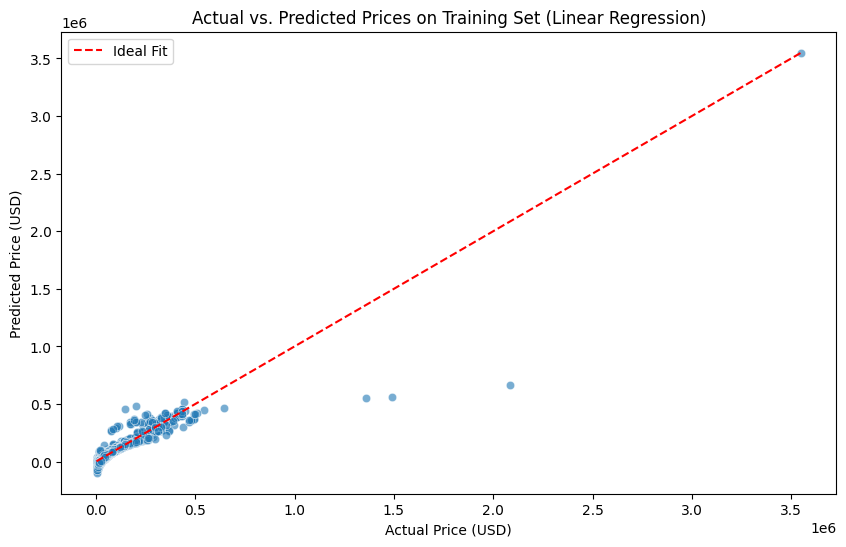

In [116]:
# Define target and categorical columns
target = 'price_usd'  # Target variable
categorical_columns = ['brand', 'country']

# Encode categorical columns using one-hot encoding
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

# Define features by excluding non-feature columns
excluded_columns = ['car name', 'price', 'price_usd']  # Columns to exclude
features = [col for col in train_data_encoded.columns if col not in excluded_columns]

# Extract features and target
X_train = train_data_encoded[features]
y_train = train_data[target]

# Train the linear regression model
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Evaluate the model on the training set
y_train_pred = linear_regression.predict(X_train)

# Visualization: Actual vs. Predicted Prices on Training Set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label="Ideal Fit")
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Actual vs. Predicted Prices on Training Set (Linear Regression)')
plt.legend()
plt.show()

Smaller Dataset Parameters (Closed-Form): [6.89770147 3.13343392 5.21870609]
Smaller Dataset Parameters (Gradient Descent): [6.89976021 3.13195068 5.21613925]

Larger Dataset Parameters (Closed-Form): [6.98997682 3.00062892 5.0221802 ]
Larger Dataset Parameters (Gradient Descent): [6.99094879 2.99990397 5.02105363]


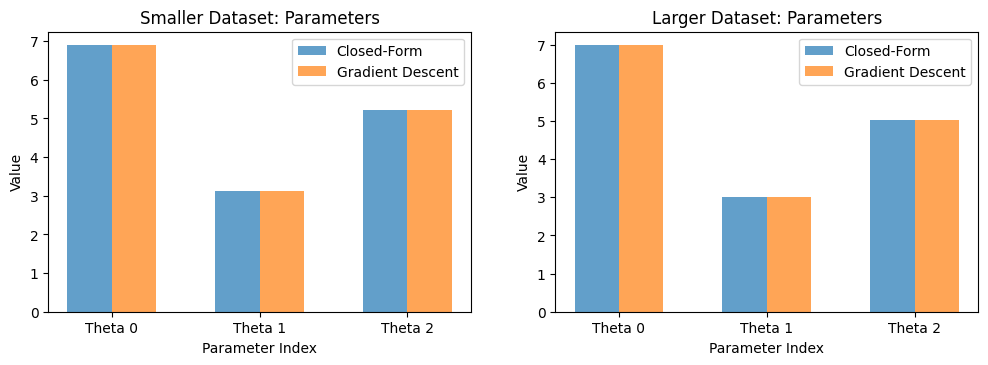

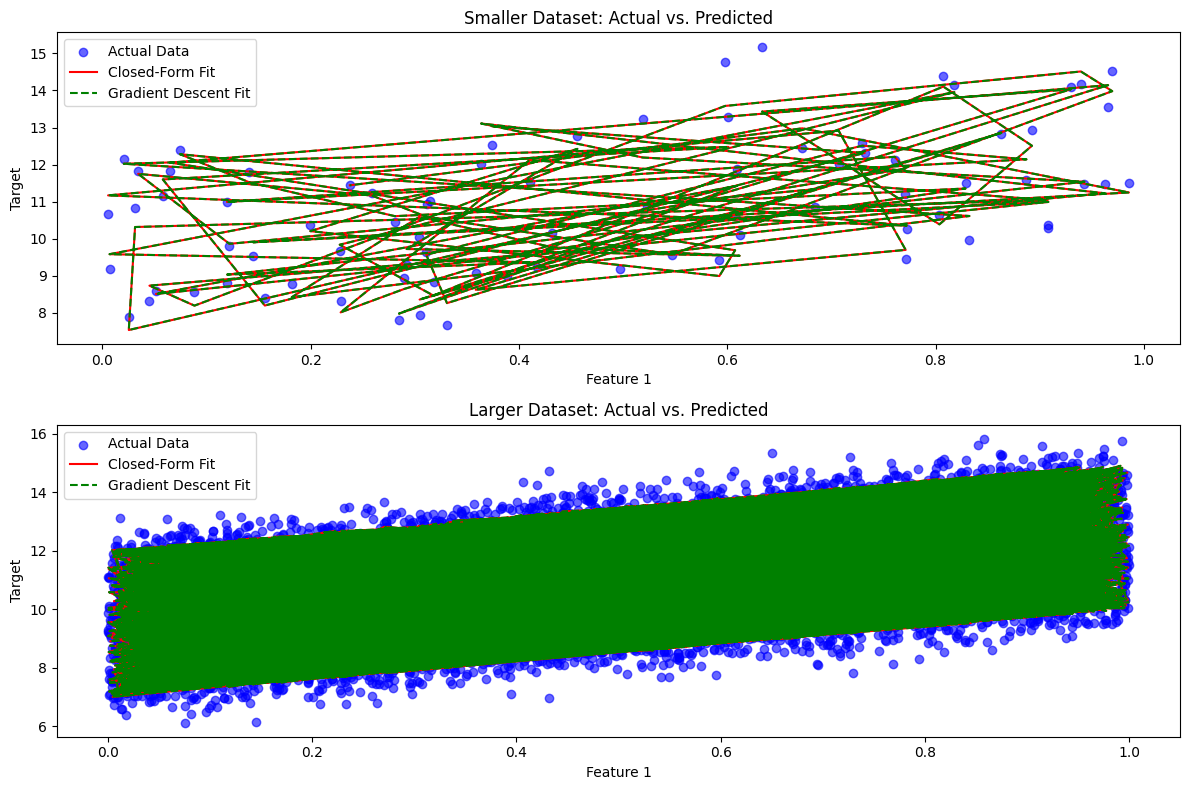

In [117]:
# Step 1: Create synthetic dataset (smaller and larger versions)
np.random.seed(42)  # For reproducibility
n_samples_small = 100
n_samples_large = 10000

# Smaller dataset
X_small = np.random.rand(n_samples_small, 2)
y_small = 3 * X_small[:, 0] + 5 * X_small[:, 1] + 7 + np.random.randn(n_samples_small) * 0.5
X_small = np.hstack((np.ones((X_small.shape[0], 1)), X_small))  # Add bias column

# Larger dataset
X_large = np.random.rand(n_samples_large, 2)
y_large = 3 * X_large[:, 0] + 5 * X_large[:, 1] + 7 + np.random.randn(n_samples_large) * 0.5
X_large = np.hstack((np.ones((X_large.shape[0], 1)), X_large))  # Add bias column

# Split smaller dataset into training and validation sets
train_ratio = 0.8
train_size_small = int(n_samples_small * train_ratio)
X_train_small, X_validation_small = X_small[:train_size_small], X_small[train_size_small:]
y_train_small, y_validation_small = y_small[:train_size_small], y_small[train_size_small:]

# Split larger dataset into training and validation sets
train_size_large = int(n_samples_large * train_ratio)
X_train_large, X_validation_large = X_large[:train_size_large], X_large[train_size_large:]
y_train_large, y_validation_large = y_large[:train_size_large], y_large[train_size_large:]

# Step 2: Closed-form solution (Training Set)
def closed_form_solution(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Train on smaller dataset (Closed-form solution)
theta_closed_form_small = closed_form_solution(X_train_small, y_train_small)

# Train on larger dataset (Closed-form solution)
theta_closed_form_large = closed_form_solution(X_train_large, y_train_large)

# Step 3: Gradient Descent Implementation (Training Set)
def gradient_descent(X, y, learning_rate=0.1, iterations=1000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(iterations):
        gradient = (1 / m) * (X.T @ (X @ theta - y))
        theta -= learning_rate * gradient
    return theta

# Train on smaller dataset (Gradient Descent)
theta_gradient_descent_small = gradient_descent(X_train_small, y_train_small, learning_rate=0.1, iterations=1000)

# Train on larger dataset (Gradient Descent)
theta_gradient_descent_large = gradient_descent(X_train_large, y_train_large, learning_rate=0.1, iterations=1000)

# Print Training Results
print("Smaller Dataset Parameters (Closed-Form):", theta_closed_form_small)
print("Smaller Dataset Parameters (Gradient Descent):", theta_gradient_descent_small)

print("\nLarger Dataset Parameters (Closed-Form):", theta_closed_form_large)
print("Larger Dataset Parameters (Gradient Descent):", theta_gradient_descent_large)

# Visualization: Closed-Form vs. Gradient Descent Parameters
plt.figure(figsize=(12, 8))

# Smaller Dataset Parameters
plt.subplot(2, 2, 1)
bar_width = 0.3
indices = np.arange(len(theta_closed_form_small))
plt.bar(indices, theta_closed_form_small, bar_width, label="Closed-Form", alpha=0.7)
plt.bar(indices + bar_width, theta_gradient_descent_small, bar_width, label="Gradient Descent", alpha=0.7)
plt.title("Smaller Dataset: Parameters")
plt.xlabel("Parameter Index")
plt.ylabel("Value")
plt.xticks(indices + bar_width / 2, [f"Theta {i}" for i in range(len(theta_closed_form_small))])
plt.legend()

# Larger Dataset Parameters
plt.subplot(2, 2, 2)
indices = np.arange(len(theta_closed_form_large))
plt.bar(indices, theta_closed_form_large, bar_width, label="Closed-Form", alpha=0.7)
plt.bar(indices + bar_width, theta_gradient_descent_large, bar_width, label="Gradient Descent", alpha=0.7)
plt.title("Larger Dataset: Parameters")
plt.xlabel("Parameter Index")
plt.ylabel("Value")
plt.xticks(indices + bar_width / 2, [f"Theta {i}" for i in range(len(theta_closed_form_large))])
plt.legend()

# Visualization: Training Data Fit
plt.figure(figsize=(12, 8))

# Smaller Dataset Fit
plt.subplot(2, 1, 1)
plt.scatter(X_train_small[:, 1], y_train_small, color='blue', alpha=0.6, label="Actual Data")
y_pred_closed_form_small = X_train_small @ theta_closed_form_small
y_pred_gradient_descent_small = X_train_small @ theta_gradient_descent_small
plt.plot(X_train_small[:, 1], y_pred_closed_form_small, label="Closed-Form Fit", color='red')
plt.plot(X_train_small[:, 1], y_pred_gradient_descent_small, label="Gradient Descent Fit", color='green', linestyle='--')
plt.title("Smaller Dataset: Actual vs. Predicted")
plt.xlabel("Feature 1")
plt.ylabel("Target")
plt.legend()

# Larger Dataset Fit
plt.subplot(2, 1, 2)
plt.scatter(X_train_large[:, 1], y_train_large, color='blue', alpha=0.6, label="Actual Data")
y_pred_closed_form_large = X_train_large @ theta_closed_form_large
y_pred_gradient_descent_large = X_train_large @ theta_gradient_descent_large
plt.plot(X_train_large[:, 1], y_pred_closed_form_large, label="Closed-Form Fit", color='red')
plt.plot(X_train_large[:, 1], y_pred_gradient_descent_large, label="Gradient Descent Fit", color='green', linestyle='--')
plt.title("Larger Dataset: Actual vs. Predicted")
plt.xlabel("Feature 1")
plt.ylabel("Target")
plt.legend()

plt.tight_layout()
plt.show()

Performing Grid Search for LASSO Regression...
Optimal λ (alpha) for LASSO: 0.5
Selected Features by LASSO: ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'car_year', 'engine_capacity_cleaned', 'price_usd_log', 'engine_capacity_cleaned_log', 'horse_power_log', 'top_speed_log', 'brand_acura', 'brand_alfa-romeo', 'brand_aston-martin', 'brand_audi', 'brand_baic', 'brand_bentley', 'brand_bestune', 'brand_bmw', 'brand_borgward', 'brand_brilliance', 'brand_bugatti', 'brand_byd', 'brand_cadillac', 'brand_changan', 'brand_chery', 'brand_chevrolet', 'brand_chrysler', 'brand_citroen', 'brand_dodge', 'brand_dorcen', 'brand_ds', 'brand_ferrari', 'brand_fiat', 'brand_ford', 'brand_foton', 'brand_gac', 'brand_geely', 'brand_genesis', 'brand_gmc', 'brand_great-wall', 'brand_haval', 'brand_honda', 'brand_hongqi', 'brand_hyundai', 'brand_infiniti', 'brand_isuzu', 'brand_jac', 'brand_jaguar', 'brand_jeep', 'brand_jetour', 'brand_kia', 'brand_kinglong', 'brand_lada', 'brand_lamborgh

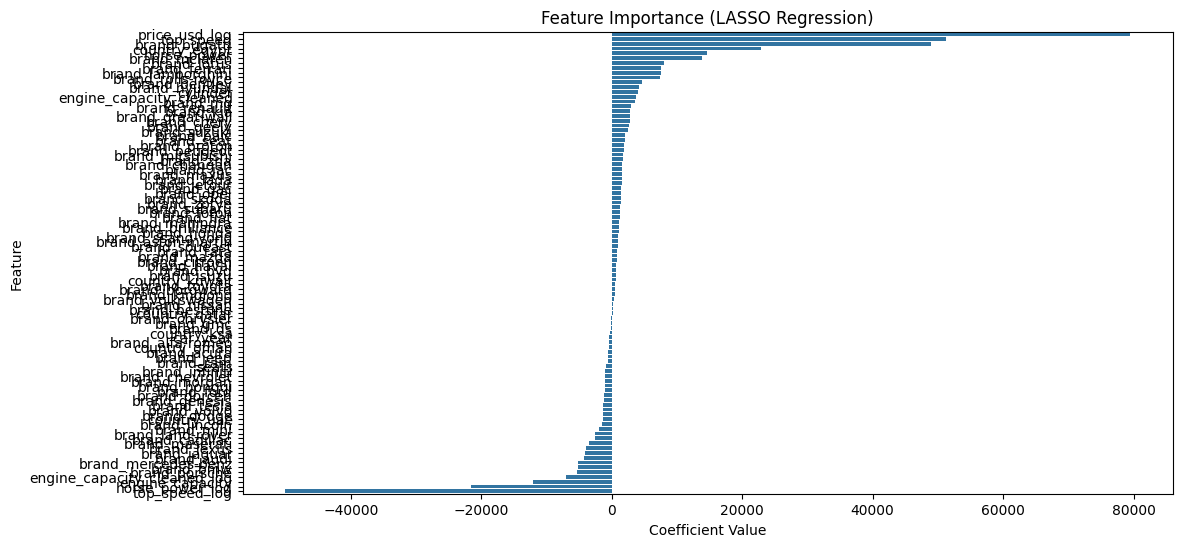

In [118]:
# Step 1: Standardize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features])  # Standardize training set features

# Step 2: Perform Grid Search to Find the Optimal λ for LASSO
print("Performing Grid Search for LASSO Regression...")
lasso_alphas = [0.5, 1, 2, 5, 10]  # Focused range for α (regularization strength)
lasso = Lasso(max_iter=10000, tol=1e-3)  # Increased iterations and adjusted tolerance

grid = GridSearchCV(estimator=lasso,
                    param_grid={'alpha': lasso_alphas},  # Regularization parameter
                    scoring='neg_mean_squared_error',    # Metric to minimize
                    cv=5)                                # 5-fold cross-validation

grid.fit(X_train_scaled, y_train)  # Fit Grid Search on training data

# Step 3: Retrieve the Best λ and Model
best_alpha = grid.best_params_['alpha']
best_lasso_model = grid.best_estimator_
print(f"Optimal λ (alpha) for LASSO: {best_alpha}")

# Step 4: Check Selected Features by LASSO
selected_features = [feature for feature, coef in zip(features, best_lasso_model.coef_) if coef != 0]
print(f"Selected Features by LASSO: {selected_features}")

# Feature Importance Table
feature_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": best_lasso_model.coef_
}).query("Coefficient != 0").sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Selected by LASSO):")
print(feature_importance)

# Visualize Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x="Coefficient", y="Feature")
plt.title("Feature Importance (LASSO Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

Performing Grid Search for Ridge Regression on Training Set...
Optimal λ (alpha) for Ridge: 0.1


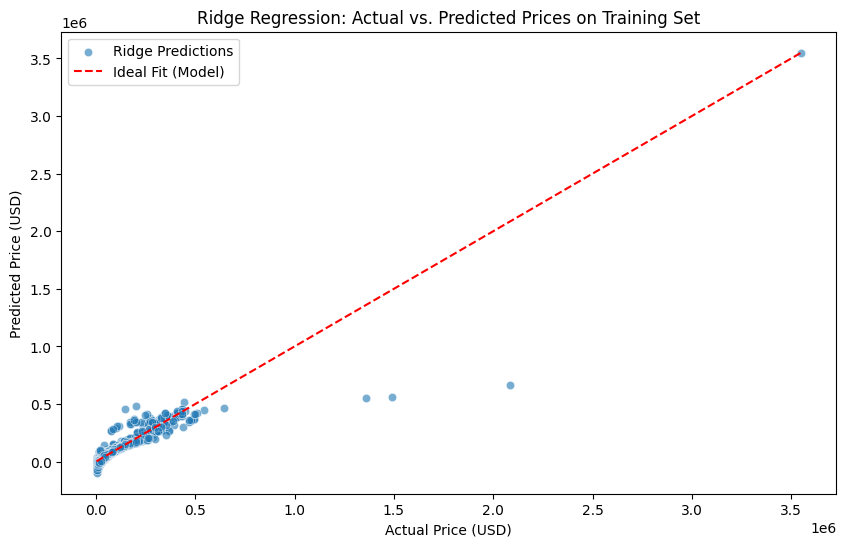

In [119]:
# Step 1: Standardize the feature values for the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features])  # Scale training features

# Step 2: Perform Grid Search to Find the Optimal λ for Ridge
print("Performing Grid Search for Ridge Regression on Training Set...")
ridge_alphas = [0.1, 1, 10, 100, 500]  # Range for λ (regularization strength)
ridge = Ridge(max_iter=10000, tol=1e-3)  # Ridge regression model

grid = GridSearchCV(estimator=ridge,
                    param_grid={'alpha': ridge_alphas},  # Regularization parameter
                    scoring='neg_mean_squared_error',    # Metric to minimize
                    cv=5)                                # 5-fold cross-validation

grid.fit(X_train_scaled, y_train)  # Fit Grid Search on training data

# Step 3: Retrieve the Best λ and Model
best_alpha = grid.best_params_['alpha']
best_ridge_model = grid.best_estimator_
print(f"Optimal λ (alpha) for Ridge: {best_alpha}")

# Step 4: Make Predictions
y_train_pred = best_ridge_model.predict(X_train_scaled)

# Step 5: Visualization: Actual vs. Predicted Prices on Training Set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, label="Ridge Predictions")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label="Ideal Fit (Model)")
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Ridge Regression: Actual vs. Predicted Prices on Training Set")
plt.legend(loc="best")
plt.show()

# Non Linear

# Polynomial Regression

Polynomial Regression:
Polynomial regression model trained with degree 2.
Polynomial regression model trained with degree 3.
Polynomial regression model trained with degree 4.
Polynomial regression model trained with degree 5.
Polynomial regression model trained with degree 6.
Polynomial regression model trained with degree 7.
Polynomial regression model trained with degree 8.
Polynomial regression model trained with degree 9.
Polynomial regression model trained with degree 10.


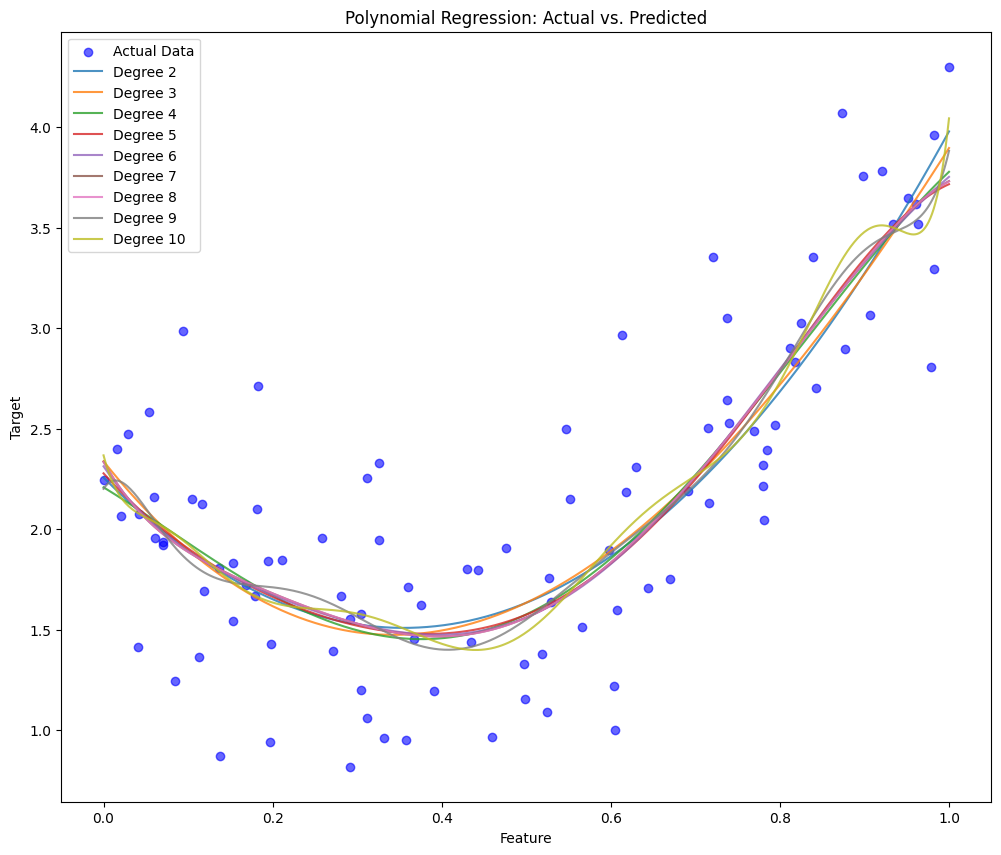

In [120]:
np.random.seed(42)
n_samples = 100
X = np.random.rand(n_samples, 1)  # Single feature for simplicity
y = 5 * X[:, 0]**2 - 3 * X[:, 0] + 2 + np.random.randn(n_samples) * 0.5  # Quadratic relationship with noise

# Normalize X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Polynomial Regression
print("Polynomial Regression:")
for degree in range(2, 11):
    # Generate polynomial features
    X_poly = np.hstack([X**d for d in range(1, degree + 1)])
    # Closed-form solution
    X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))  # Add bias column
    theta = np.linalg.inv(X_poly.T @ X_poly) @ X_poly.T @ y  # Closed-form solution
    # Predictions
    y_pred = X_poly @ theta
    # Print polynomial degree (no metrics since this is just fitting)
    print(f"Polynomial regression model trained with degree {degree}.")

# Visualization for Polynomial Regression
plt.figure(figsize=(12, 10))
plt.scatter(X, y, label="Actual Data", color="blue", alpha=0.6)

x_range = np.linspace(0, 1, 500).reshape(-1, 1)  # Generate smooth range for X

for degree in range(2, 11):
    # Generate polynomial features for training set
    X_poly_train = np.hstack([X**d for d in range(1, degree + 1)])
    X_poly_train = np.hstack((np.ones((X_poly_train.shape[0], 1)), X_poly_train))  # Add bias column
    theta = np.linalg.inv(X_poly_train.T @ X_poly_train) @ X_poly_train.T @ y  # Closed-form solution

    # Generate polynomial features for smooth X range
    X_poly_smooth = np.hstack([x_range**d for d in range(1, degree + 1)])
    X_poly_smooth = np.hstack((np.ones((X_poly_smooth.shape[0], 1)), X_poly_smooth))  # Add bias column

    # Predictions for smooth range
    y_smooth_pred = X_poly_smooth @ theta
    plt.plot(x_range, y_smooth_pred, label=f"Degree {degree}", alpha=0.8)

plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Polynomial Regression: Actual vs. Predicted")
plt.legend()
plt.show()

# Radial Basis Function (RBF) Regression


RBF Regression:


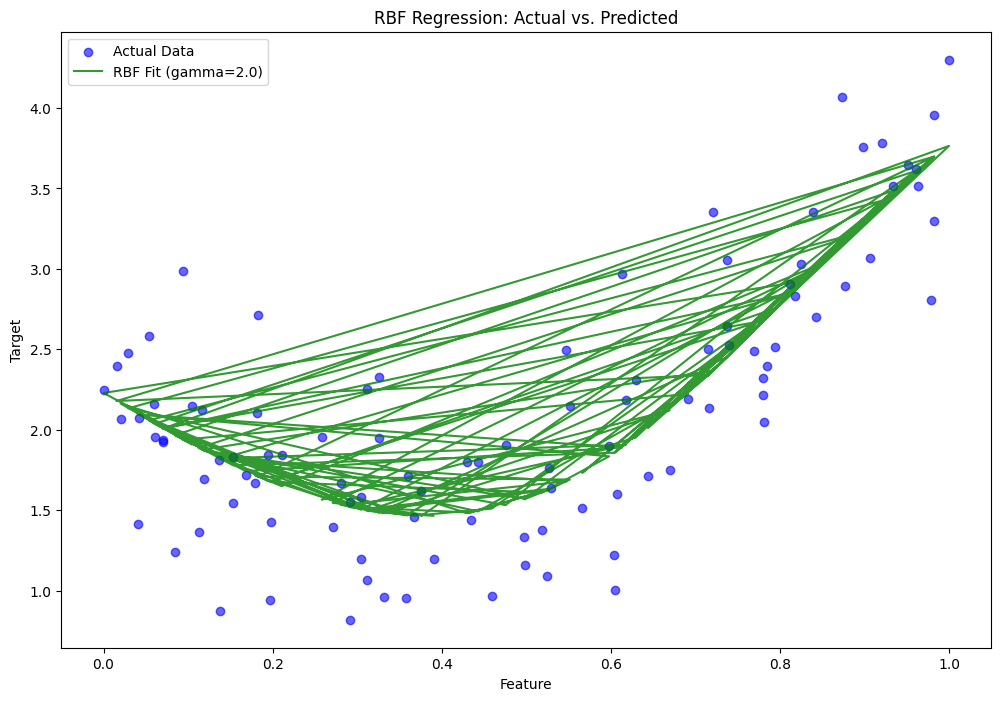

In [121]:
# Radial Basis Function (RBF) Regression
print("\nRBF Regression:")

def rbf_kernel(X, gamma=1.0):  # Adjust gamma for a smoother fit
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X[i] - X[j])**2)
    return K

# Compute the RBF Kernel with adjusted gamma
gamma = 2.0  # Adjusted gamma for smoother behavior
K = rbf_kernel(X, gamma)

# Closed-form solution in the kernel space
alpha = np.linalg.inv(K.T @ K + 1e-6 * np.eye(K.shape[1])) @ K.T @ y  # Ridge regularization to stabilize

# Predictions
y_pred_rbf = K @ alpha

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(X, y, label="Actual Data", color='blue', alpha=0.6)
plt.plot(X, y_pred_rbf, label=f"RBF Fit (gamma={gamma})", color='green', alpha=0.8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("RBF Regression: Actual vs. Predicted")
plt.legend()
plt.show()

# Model Evaluation on Validation Set

Validation MSE: 660653214.82
Validation MAE: 10054.11
Validation R-squared: 0.88


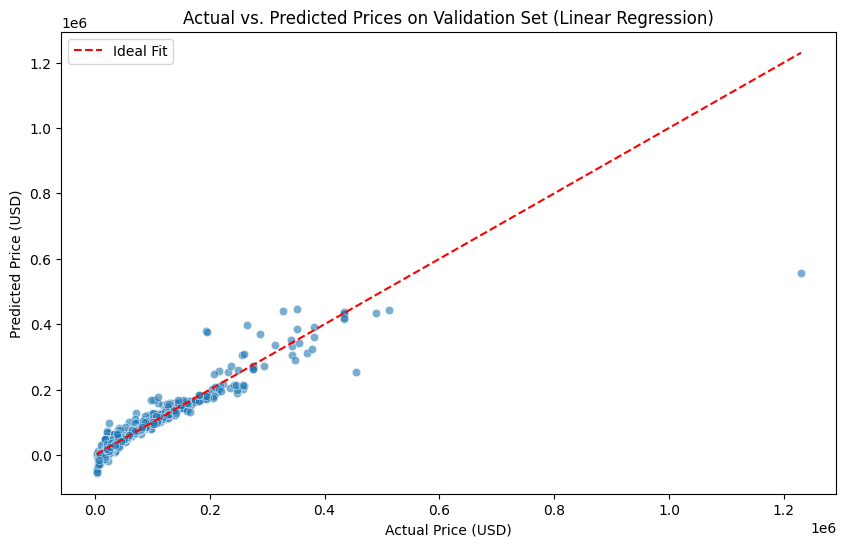

In [122]:
# Define target and categorical columns
target = 'price_usd'  # Target variable
categorical_columns = ['brand', 'country']

# Encode categorical features for the validation dataset
validation_data_encoded = pd.get_dummies(validation_data, columns=categorical_columns, drop_first=True)

# Define features by excluding non-feature columns
excluded_columns = ['car name', 'price', 'price_usd']  # Columns to exclude
features = [col for col in validation_data_encoded.columns if col not in excluded_columns]

# Extract the target values
y_validation = validation_data[target]

# Train the linear regression model using the validation set
linear_regression = LinearRegression()
linear_regression.fit(validation_data_encoded[features], y_validation)

# Evaluate the model on the validation set
y_val_pred = linear_regression.predict(validation_data_encoded[features])

# Calculate validation metrics
mse_val = mean_squared_error(y_validation, y_val_pred)
mae_val = mean_absolute_error(y_validation, y_val_pred)
r2_val = r2_score(y_validation, y_val_pred)

# Print validation metrics
print(f"Validation MSE: {mse_val:.2f}")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation R-squared: {r2_val:.2f}")

# Visualization: Actual vs. Predicted Prices on Validation Set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_validation, y=y_val_pred, alpha=0.6)
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label="Ideal Fit")
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.title('Actual vs. Predicted Prices on Validation Set (Linear Regression)')
plt.legend()
plt.show()

# Linear Regression Using The Closed-Form Solution & Gradient Descent

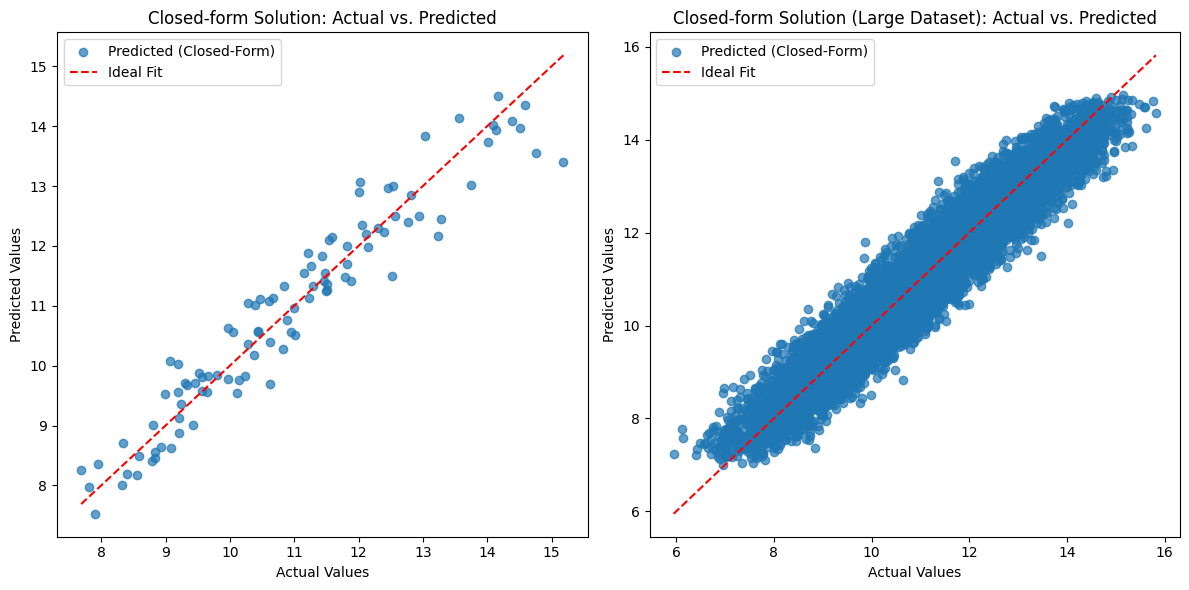

Validation Set Metrics (Closed-Form):

Smaller Dataset:
  MSE: 0.2453, MAE: 0.3943, R²: 0.9240

Larger Dataset:
  MSE: 0.2446, MAE: 0.3953, R²: 0.9207


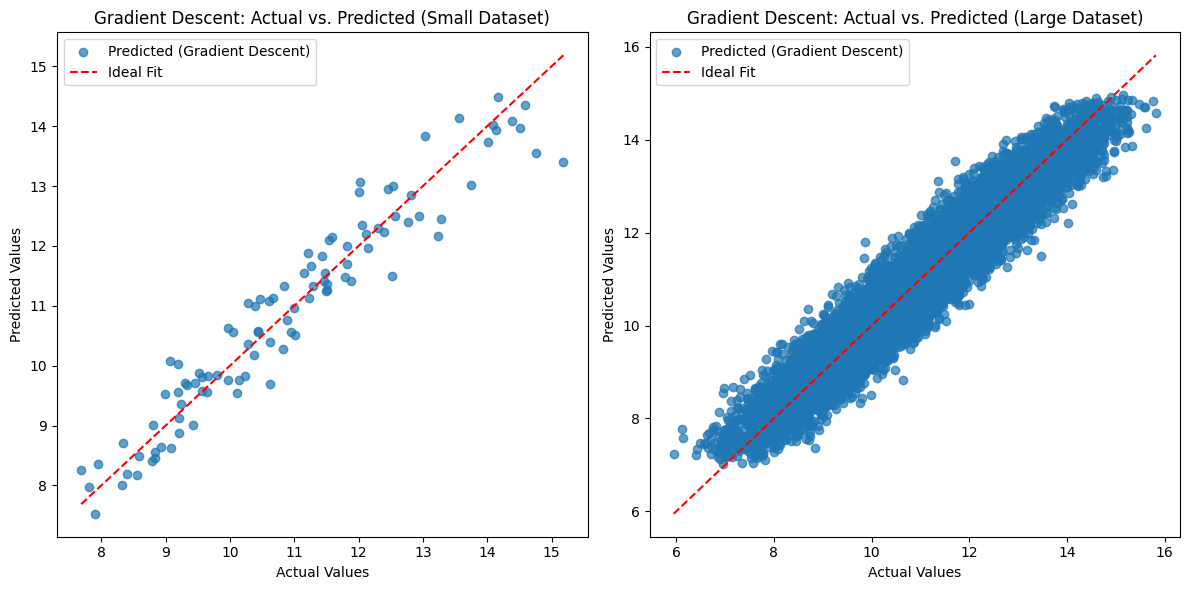


Validation Set Metrics (Gradient Descent):

Smaller Dataset:
  MSE: 0.2453, MAE: 0.3943, R²: 0.9240

Larger Dataset:
  MSE: 0.2446, MAE: 0.3953, R²: 0.9207


In [123]:
# Step 1: Create synthetic dataset (only validation set considered)
np.random.seed(42)  # For reproducibility
n_samples_small = 100
n_samples_large = 10000

# Validation dataset
X_validation_small = np.random.rand(n_samples_small, 2)
y_validation_small = 3 * X_validation_small[:, 0] + 5 * X_validation_small[:, 1] + 7 + np.random.randn(n_samples_small) * 0.5
X_validation_small = np.hstack((np.ones((X_validation_small.shape[0], 1)), X_validation_small))  # Add bias column

X_validation_large = np.random.rand(n_samples_large, 2)
y_validation_large = 3 * X_validation_large[:, 0] + 5 * X_validation_large[:, 1] + 7 + np.random.randn(n_samples_large) * 0.5
X_validation_large = np.hstack((np.ones((X_validation_large.shape[0], 1)), X_validation_large))  # Add bias column

# Step 2: Closed-form solution
def closed_form_solution(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Closed-form on smaller dataset
theta_closed_form_small = closed_form_solution(X_validation_small, y_validation_small)
y_val_pred_closed_form_small = X_validation_small @ theta_closed_form_small

# Metrics for closed-form solution (smaller dataset)
mse_closed_form_small = np.mean((y_validation_small - y_val_pred_closed_form_small) ** 2)
mae_closed_form_small = np.mean(np.abs(y_validation_small - y_val_pred_closed_form_small))
r2_closed_form_small = 1 - (np.sum((y_validation_small - y_val_pred_closed_form_small) ** 2) /
                            np.sum((y_validation_small - np.mean(y_validation_small)) ** 2))

# Closed-form on larger dataset
theta_closed_form_large = closed_form_solution(X_validation_large, y_validation_large)
y_val_pred_closed_form_large = X_validation_large @ theta_closed_form_large

# Metrics for closed-form solution (larger dataset)
mse_closed_form_large = np.mean((y_validation_large - y_val_pred_closed_form_large) ** 2)
mae_closed_form_large = np.mean(np.abs(y_validation_large - y_val_pred_closed_form_large))
r2_closed_form_large = 1 - (np.sum((y_validation_large - y_val_pred_closed_form_large) ** 2) /
                            np.sum((y_validation_large - np.mean(y_validation_large)) ** 2))

# Visualization 1: Actual vs. Predicted (Validation Set - Small Dataset)
plt.figure(figsize=(12, 6))

# Closed-form solution plot (Small Dataset)
plt.subplot(1, 2, 1)
plt.scatter(y_validation_small, y_val_pred_closed_form_small, alpha=0.7, label="Predicted (Closed-Form)")
plt.plot([y_validation_small.min(), y_validation_small.max()],
         [y_validation_small.min(), y_validation_small.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Closed-form Solution: Actual vs. Predicted")
plt.legend()

# Closed-form solution plot (Large Dataset)
plt.subplot(1, 2, 2)
plt.scatter(y_validation_large, y_val_pred_closed_form_large, alpha=0.7, label="Predicted (Closed-Form)")
plt.plot([y_validation_large.min(), y_validation_large.max()],
         [y_validation_large.min(), y_validation_large.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Closed-form Solution (Large Dataset): Actual vs. Predicted")
plt.legend()

plt.tight_layout()
plt.show()

# Print Results
print("Validation Set Metrics (Closed-Form):")
print("\nSmaller Dataset:")
print(f"  MSE: {mse_closed_form_small:.4f}, MAE: {mae_closed_form_small:.4f}, R²: {r2_closed_form_small:.4f}")
print("\nLarger Dataset:")
print(f"  MSE: {mse_closed_form_large:.4f}, MAE: {mae_closed_form_large:.4f}, R²: {r2_closed_form_large:.4f}")

# Step 3: Gradient Descent Implementation
def gradient_descent(X, y, learning_rate=0.1, iterations=1000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(iterations):
        gradient = (1 / m) * (X.T @ (X @ theta - y))
        theta -= learning_rate * gradient
    return theta

# Train on smaller validation dataset (Gradient Descent)
theta_gradient_descent_small = gradient_descent(X_validation_small, y_validation_small, learning_rate=0.1, iterations=1000)
y_val_pred_gradient_small = X_validation_small @ theta_gradient_descent_small

# Train on larger validation dataset (Gradient Descent)
theta_gradient_descent_large = gradient_descent(X_validation_large, y_validation_large, learning_rate=0.1, iterations=1000)
y_val_pred_gradient_large = X_validation_large @ theta_gradient_descent_large

# Visualization: Gradient Descent - Actual vs. Predicted (Validation Set)
plt.figure(figsize=(12, 6))

# Gradient Descent plot (Small Dataset)
plt.subplot(1, 2, 1)
plt.scatter(y_validation_small, y_val_pred_gradient_small, alpha=0.7, label="Predicted (Gradient Descent)")
plt.plot([y_validation_small.min(), y_validation_small.max()],
         [y_validation_small.min(), y_validation_small.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Descent: Actual vs. Predicted (Small Dataset)")
plt.legend()

# Gradient Descent plot (Large Dataset)
plt.subplot(1, 2, 2)
plt.scatter(y_validation_large, y_val_pred_gradient_large, alpha=0.7, label="Predicted (Gradient Descent)")
plt.plot([y_validation_large.min(), y_validation_large.max()],
         [y_validation_large.min(), y_validation_large.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Descent: Actual vs. Predicted (Large Dataset)")
plt.legend()

plt.tight_layout()
plt.show()

# Print Results for Gradient Descent
print("\nValidation Set Metrics (Gradient Descent):")
print("\nSmaller Dataset:")
mse_gradient_small = np.mean((y_validation_small - y_val_pred_gradient_small) ** 2)
mae_gradient_small = np.mean(np.abs(y_validation_small - y_val_pred_gradient_small))
r2_gradient_small = 1 - (np.sum((y_validation_small - y_val_pred_gradient_small) ** 2) /
                         np.sum((y_validation_small - np.mean(y_validation_small)) ** 2))
print(f"  MSE: {mse_gradient_small:.4f}, MAE: {mae_gradient_small:.4f}, R²: {r2_gradient_small:.4f}")

print("\nLarger Dataset:")
mse_gradient_large = np.mean((y_validation_large - y_val_pred_gradient_large) ** 2)
mae_gradient_large = np.mean(np.abs(y_validation_large - y_val_pred_gradient_large))
r2_gradient_large = 1 - (np.sum((y_validation_large - y_val_pred_gradient_large) ** 2) /
                         np.sum((y_validation_large - np.mean(y_validation_large)) ** 2))
print(f"  MSE: {mse_gradient_large:.4f}, MAE: {mae_gradient_large:.4f}, R²: {r2_gradient_large:.4f}")


# LASSO Regression (L1 Regularization)

Performing Grid Search for LASSO Regression...
Optimal λ (alpha) for LASSO: 10

Validation Metrics:
Mean Squared Error (MSE): 660760986.18
Mean Absolute Error (MAE): 10021.94
R-squared (R²): 0.88

Feature Importance:
              Feature   Coefficient
7       price_usd_log  56395.717371
2         horse_power  55990.934934
63      brand_mclaren  18285.943724
90      country_egypt  16254.115695
54  brand_lamborghini   9062.100262
..                ...           ...
74          brand_ram  -2003.333424
14         brand_audi  -2052.187509
23     brand_cadillac  -2135.090447
0     engine_capacity  -7707.154917
9     horse_power_log -54983.916064

[87 rows x 2 columns]


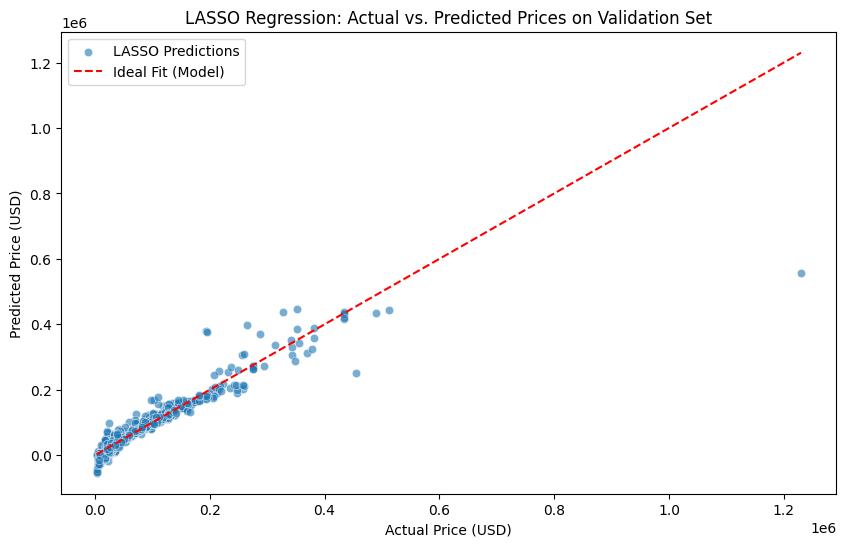

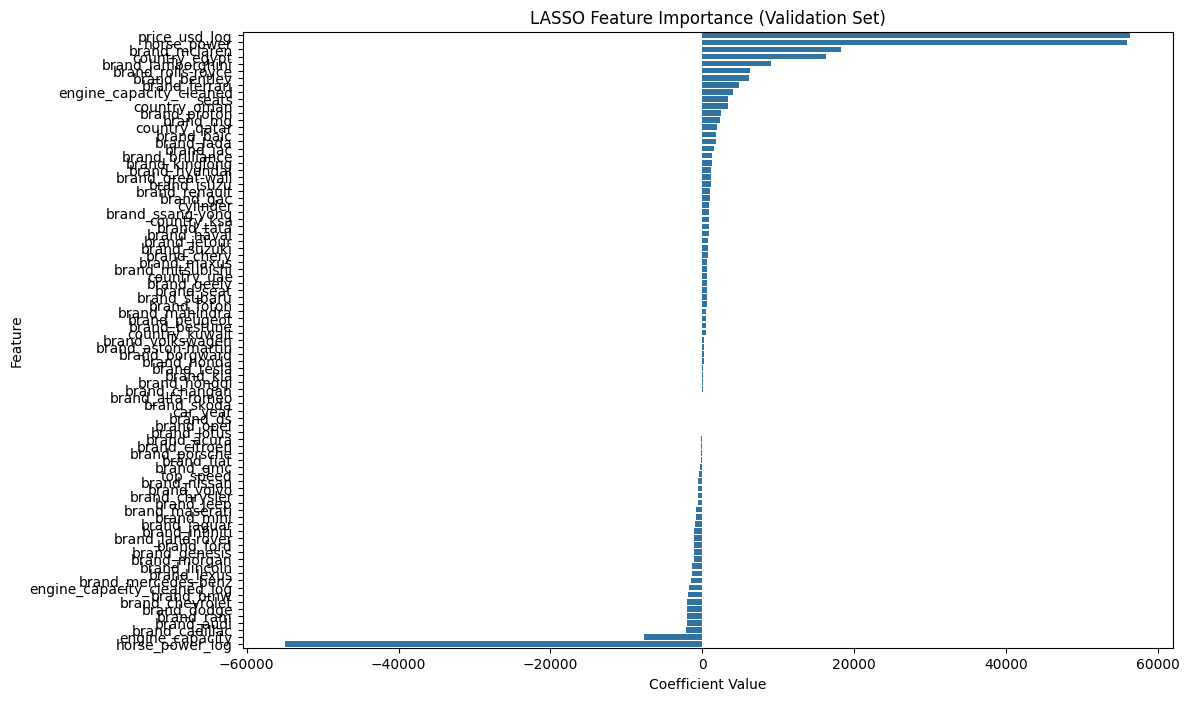

In [124]:
# Define categorical columns
categorical_columns = ['brand', 'country']

# Encode training and validation data
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
validation_data_encoded = pd.get_dummies(validation_data, columns=categorical_columns, drop_first=True)

# Align columns to ensure consistent feature sets
X_train, X_validation = train_data_encoded.align(validation_data_encoded, join='left', axis=1, fill_value=0)

# Exclude columns that are not features
excluded_columns = ['car name', 'price', 'price_usd']
features = [col for col in X_train.columns if col not in excluded_columns]

# Target variable
y_train = train_data['price_usd']
y_validation = validation_data['price_usd']

# Step 1: Standardize the feature values
scaler = StandardScaler()
X_validation_scaled = scaler.fit_transform(X_validation[features])  # Standardize validation set

# Step 2: Perform Grid Search to Find the Optimal λ for LASSO
print("Performing Grid Search for LASSO Regression...")
lasso_alphas = [0.5, 1, 2, 5, 10]  # Range for α (regularization strength)
lasso = Lasso(max_iter=10000, tol=1e-3)  # Increased iterations and adjusted tolerance

grid = GridSearchCV(estimator=lasso,
                    param_grid={'alpha': lasso_alphas},
                    scoring='neg_mean_squared_error',
                    cv=5)

grid.fit(X_validation_scaled, y_validation)

# Step 3: Retrieve the Best λ and Model
best_alpha = grid.best_params_['alpha']
best_lasso_model = grid.best_estimator_
print(f"Optimal λ (alpha) for LASSO: {best_alpha}")

# Step 4: Predictions on Validation Set
y_val_pred = best_lasso_model.predict(X_validation_scaled)

# Step 5: Calculate Metrics
mse = mean_squared_error(y_validation, y_val_pred)
mae = mean_absolute_error(y_validation, y_val_pred)
r2 = r2_score(y_validation, y_val_pred)

print("\nValidation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Step 6: Feature Importance Table
feature_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": best_lasso_model.coef_
}).query("Coefficient != 0").sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Step 7: Visualizations
# Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_validation, y=y_val_pred, alpha=0.6, label="LASSO Predictions")
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label="Ideal Fit (Model)")
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("LASSO Regression: Actual vs. Predicted Prices on Validation Set")
plt.legend(loc="best")
plt.show()

# Feature Importance Bar Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x="Coefficient", y="Feature")
plt.title("LASSO Feature Importance (Validation Set)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# Ridge Regression (L2 Regularization)

Performing Grid Search for Ridge Regression on Validation Set...
Optimal λ (alpha) for Ridge: 1
Validation MSE: 660892933.21
Validation MAE: 9982.06
Validation R-squared: 0.88


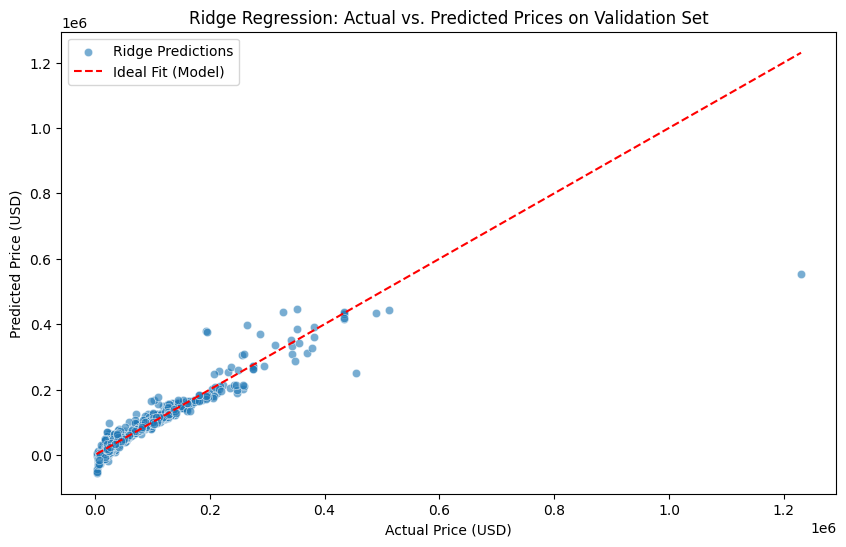

In [125]:
# Step 1: Standardize the feature values for validation set
scaler = StandardScaler()
X_validation_scaled = scaler.fit_transform(X_validation[features])  # Scale validation features

# Step 2: Perform Grid Search to Find the Optimal λ for Ridge
print("Performing Grid Search for Ridge Regression on Validation Set...")
ridge_alphas = [0.1, 1, 10, 100, 500]  # Range for λ (regularization strength)
ridge = Ridge(max_iter=10000, tol=1e-3)  # Ridge regression model

grid = GridSearchCV(estimator=ridge,
                    param_grid={'alpha': ridge_alphas},  # Regularization parameter
                    scoring='neg_mean_squared_error',    # Metric to minimize
                    cv=5)                                # 5-fold cross-validation

grid.fit(X_validation_scaled, y_validation)  # Fit Grid Search on validation data

# Step 3: Retrieve the Best λ and Model
best_alpha = grid.best_params_['alpha']
best_ridge_model = grid.best_estimator_
print(f"Optimal λ (alpha) for Ridge: {best_alpha}")

# Step 4: Make Predictions
y_val_pred = best_ridge_model.predict(X_validation_scaled)

# Step 5: Calculate Metrics
mse_val = mean_squared_error(y_validation, y_val_pred)
mae_val = mean_absolute_error(y_validation, y_val_pred)
r2_val = r2_score(y_validation, y_val_pred)

# Print Metrics
print(f"Validation MSE: {mse_val:.2f}")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation R-squared: {r2_val:.2f}")

# Step 6: Visualization: Actual vs. Predicted Prices on Validation Set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_validation, y=y_val_pred, alpha=0.6, label="Ridge Predictions")
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label="Ideal Fit (Model)")
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Ridge Regression: Actual vs. Predicted Prices on Validation Set")
plt.legend(loc="best")
plt.show()

# Non-Linear

# Polynomial Regression

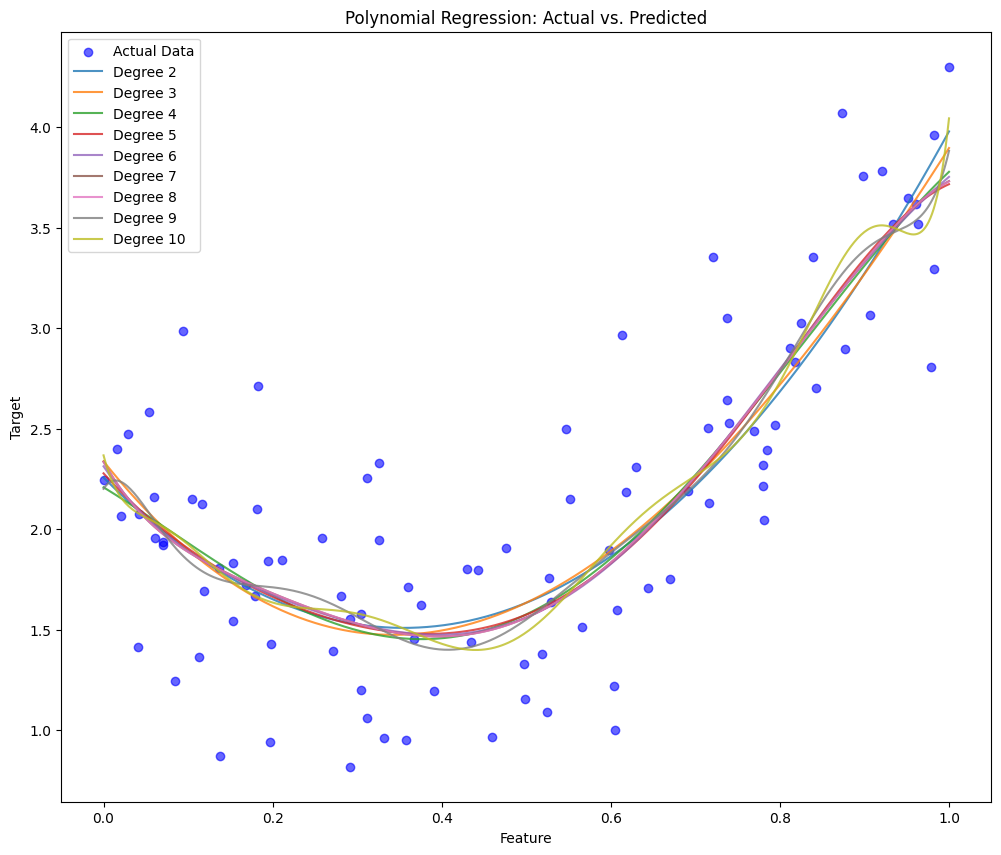

,Degree,MSE,MAE,R-squared
0,2,0.194298,0.338932,0.694370
1,3,0.193116,0.341737,0.696230
2,4,0.190885,0.340094,0.699740
3,5,0.190369,0.338777,0.700552
4,6,0.190240,0.338934,0.700754
5,7,0.190196,0.338589,0.700823
6,8,0.190196,0.338566,0.700823
7,9,0.188091,0.337234,0.704134
8,10,0.184977,0.335265,0.709032


In [126]:
# Generate synthetic validation dataset
np.random.seed(42)
n_samples = 100
X_val = np.random.rand(n_samples, 1)  # Single feature for simplicity
y_val = 5 * X_val[:, 0]**2 - 3 * X_val[:, 0] + 2 + np.random.randn(n_samples) * 0.5  # Quadratic relationship with noise

# Normalize X
scaler = MinMaxScaler()
X_val = scaler.fit_transform(X_val)

# Polynomial Regression
metrics = []

# Plot setup
plt.figure(figsize=(12, 10))
plt.scatter(X_val, y_val, label="Actual Data", color="blue", alpha=0.6)

x_range = np.linspace(0, 1, 500).reshape(-1, 1)  # Generate smooth range for X

for degree in range(2, 11):
    # Generate polynomial features for validation set
    X_poly_val = np.hstack([X_val**d for d in range(1, degree + 1)])
    X_poly_val = np.hstack((np.ones((X_poly_val.shape[0], 1)), X_poly_val))  # Add bias column

    # Closed-form solution
    theta = np.linalg.inv(X_poly_val.T @ X_poly_val) @ X_poly_val.T @ y_val  # Closed-form solution

    # Generate polynomial features for smooth X range
    X_poly_smooth = np.hstack([x_range**d for d in range(1, degree + 1)])
    X_poly_smooth = np.hstack((np.ones((X_poly_smooth.shape[0], 1)), X_poly_smooth))  # Add bias column

    # Predictions
    y_val_pred = X_poly_val @ theta
    y_smooth_pred = X_poly_smooth @ theta

    # Calculate metrics
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    metrics.append((degree, mse, mae, r2))

    # Plot
    plt.plot(x_range, y_smooth_pred, label=f"Degree {degree}", alpha=0.8)

plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Polynomial Regression: Actual vs. Predicted")
plt.legend()
plt.show()

# Display metrics using pandas
metrics_df = pd.DataFrame(metrics, columns=["Degree", "MSE", "MAE", "R-squared"])
metrics_df

# Radial Basis Function (RBF) Regression

RBF Validation MSE: 0.1906
RBF Validation MAE: 0.3393
RBF Validation R²: 0.7002


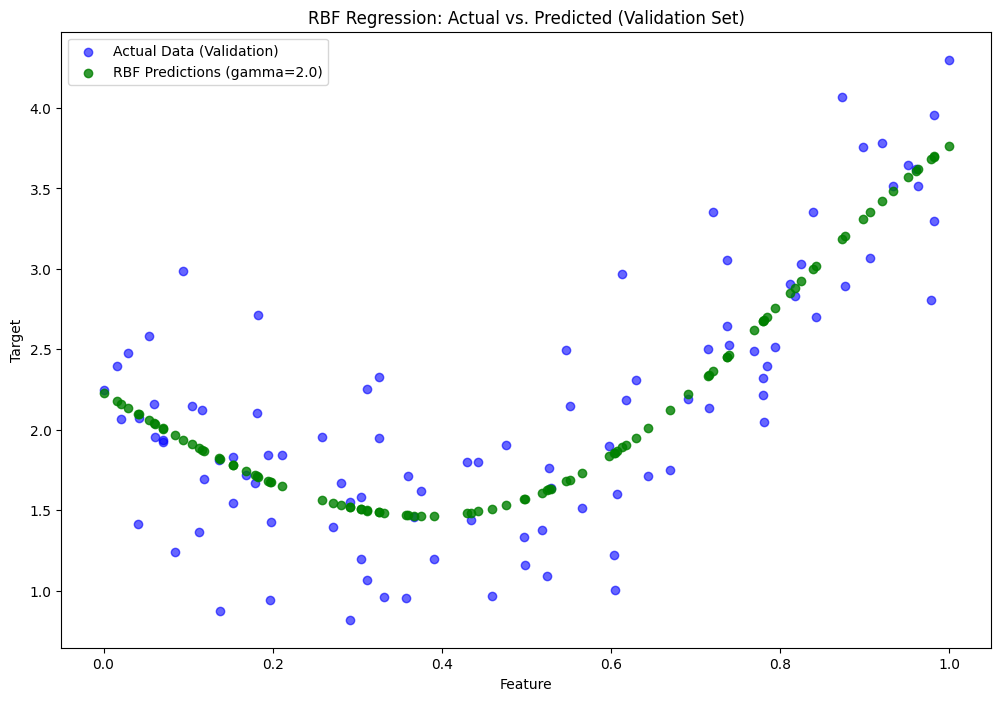

In [127]:
# Example Dataset
np.random.seed(42)
n_samples = 100
X_validation = np.random.rand(n_samples, 1)  # Single feature for simplicity
y_validation = 5 * X_validation[:, 0]**2 - 3 * X_validation[:, 0] + 2 + np.random.randn(n_samples) * 0.5  # Quadratic relationship with noise

# Normalize the validation dataset
scaler = MinMaxScaler()
X_validation = scaler.fit_transform(X_validation)

# Define the RBF kernel function
def rbf_kernel(X1, gamma=1.0):
    n_samples_1 = X1.shape[0]
    K = np.zeros((n_samples_1, n_samples_1))
    for i in range(n_samples_1):
        for j in range(n_samples_1):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X1[i] - X1[j])**2)
    return K

# Compute RBF Kernel for validation set
gamma = 2.0  # Adjusted gamma for smoother behavior
K_val = rbf_kernel(X_validation, gamma)  # Kernel for validation set

# Closed-form solution in the kernel space (Ridge regularization)
alpha = np.linalg.inv(K_val.T @ K_val + 1e-6 * np.eye(K_val.shape[1])) @ K_val.T @ y_validation

# Predictions on validation set
y_val_pred_rbf = K_val @ alpha

# Calculate metrics
mse_rbf = mean_squared_error(y_validation, y_val_pred_rbf)
mae_rbf = mean_absolute_error(y_validation, y_val_pred_rbf)
r2_rbf = r2_score(y_validation, y_val_pred_rbf)

# Print metrics
print(f"RBF Validation MSE: {mse_rbf:.4f}")
print(f"RBF Validation MAE: {mae_rbf:.4f}")
print(f"RBF Validation R²: {r2_rbf:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_validation, y_validation, label="Actual Data (Validation)", color='blue', alpha=0.6)
plt.scatter(X_validation, y_val_pred_rbf, label=f"RBF Predictions (gamma={gamma})", color='green', alpha=0.8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("RBF Regression: Actual vs. Predicted (Validation Set)")
plt.legend()
plt.show()

# Feature Selection with Forward Selection

In [128]:
# Example dataset
np.random.seed(42)
n_samples = 100

# Your feature names (example feature set)
feature_names = [
    "car name", "engine_capacity", "cylinder", "horse_power", "top_speed", 
    "seats", "brand", "country", "car_year", "engine_capacity_cleaned", 
    "price_usd_log", "engine_capacity_cleaned_log", "horse_power_log", "top_speed_log"
]

n_features = len(feature_names)

# Generate synthetic dataset with noise
X = np.random.rand(n_samples, n_features)  # Random features
y = 5 * X[:, 0] + 3 * X[:, 1] - 2 * X[:, 2] + np.random.randn(n_samples) * 0.5  # Target with noise

# Split dataset into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

# Forward Selection Function
def forward_selection_with_names(X_train, y_train, X_validation, y_validation, feature_names, max_features=None):
    """
    Perform forward selection to select the best features for a linear regression model.
    Args:
        X_train: Training features (2D array)
        y_train: Training target (1D array)
        X_validation: Validation features (2D array)
        y_validation: Validation target (1D array)
        feature_names: List of feature names corresponding to the columns in X_train
        max_features: Maximum number of features to select (default: None, i.e., select all)
    Returns:
        selected_features: List of selected feature indices
        selected_feature_names: List of selected feature names
        unselected_feature_names: List of unselected feature names
    """
    n_features = X_train.shape[1]
    selected_features = []  # Indices of selected features
    remaining_features = list(range(n_features))  # Indices of remaining features
    best_validation_error = float('inf')  # Best validation error so far

    if max_features is None:
        max_features = n_features  # Default to all features if max_features not specified

    while len(selected_features) < max_features and remaining_features:
        best_feature = None  # Feature that improves the model the most
        for feature in remaining_features:
            # Try adding this feature to the model
            candidate_features = selected_features + [feature]
            X_train_subset = X_train[:, candidate_features]
            X_validation_subset = X_validation[:, candidate_features]

            # Closed-form solution for linear regression
            theta = np.linalg.inv(X_train_subset.T @ X_train_subset) @ X_train_subset.T @ y_train

            # Predict on validation set
            y_val_pred = X_validation_subset @ theta

            # Calculate validation error (MSE)
            validation_error = mean_squared_error(y_validation, y_val_pred)

            if validation_error < best_validation_error:
                best_validation_error = validation_error
                best_feature = feature

        if best_feature is not None:
            # Add the best feature to the selected features list
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"Selected feature {feature_names[best_feature]} with validation error {best_validation_error:.4f}")
        else:
            # No improvement found, stop the selection process
            print("No further improvement. Stopping.")
            break

    selected_feature_names = [feature_names[i] for i in selected_features]
    unselected_feature_names = [feature_names[i] for i in remaining_features]

    return selected_features, selected_feature_names, unselected_feature_names

# Perform forward selection
selected_features, selected_feature_names, unselected_feature_names = forward_selection_with_names(
    X_train, y_train, X_validation, y_validation, feature_names
)

# Print results
print(f"\nSelected Features: {selected_feature_names}")
print(f"Unselected Features: {unselected_feature_names}")

Selected feature car name with validation error 1.3469
Selected feature engine_capacity with validation error 0.5397
Selected feature cylinder with validation error 0.3727
Selected feature brand with validation error 0.2952
Selected feature car_year with validation error 0.2791
Selected feature top_speed with validation error 0.2525
Selected feature seats with validation error 0.2522
No further improvement. Stopping.

Selected Features: ['car name', 'engine_capacity', 'cylinder', 'brand', 'car_year', 'top_speed', 'seats']
Unselected Features: ['horse_power', 'country', 'engine_capacity_cleaned', 'price_usd_log', 'engine_capacity_cleaned_log', 'horse_power_log', 'top_speed_log']


# Model Evaluation on Test Set

RBF Test MSE: 0.1906
RBF Test MAE: 0.3393
RBF Test R²: 0.7002


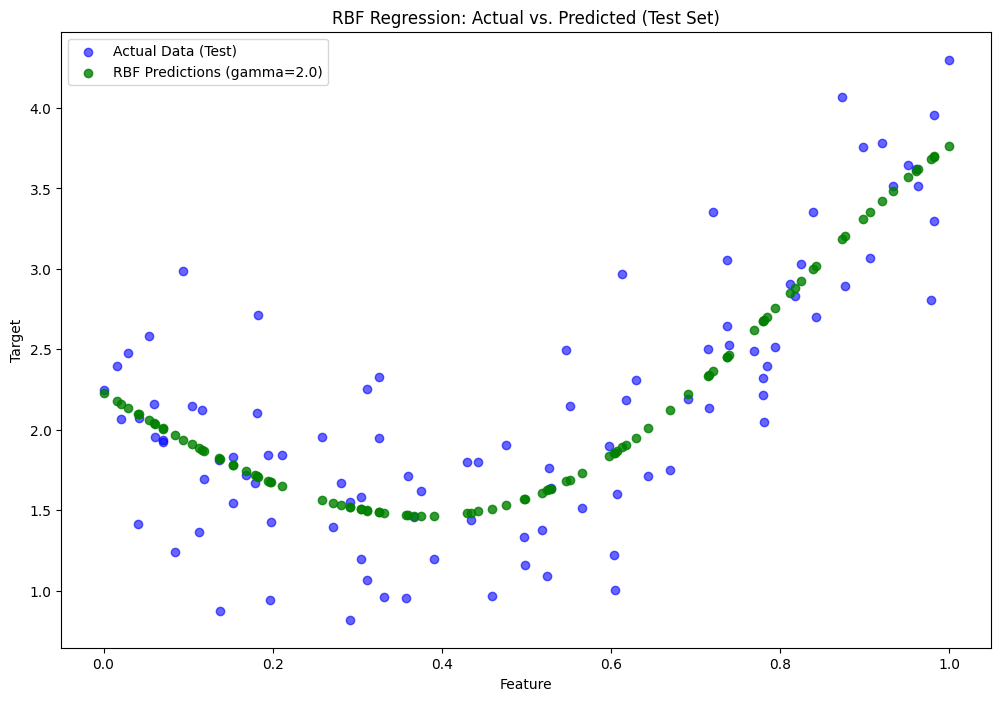

In [129]:
# Example Dataset (Test Set)
np.random.seed(42)
n_samples = 100
X_test = np.random.rand(n_samples, 1)  # Single feature for simplicity
y_test = 5 * X_test[:, 0]**2 - 3 * X_test[:, 0] + 2 + np.random.randn(n_samples) * 0.5  # Quadratic relationship with noise

# Normalize the test dataset
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

# Define the RBF kernel function
def rbf_kernel(X1, gamma=1.0):
    n_samples_1 = X1.shape[0]
    K = np.zeros((n_samples_1, n_samples_1))
    for i in range(n_samples_1):
        for j in range(n_samples_1):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X1[i] - X1[j])**2)
    return K

# Compute RBF Kernel for test set
gamma = 2.0  # Adjusted gamma for smoother behavior
K_test = rbf_kernel(X_test, gamma)  # Kernel for test set

# Closed-form solution in the kernel space (Ridge regularization)
alpha = np.linalg.inv(K_test.T @ K_test + 1e-6 * np.eye(K_test.shape[1])) @ K_test.T @ y_test

# Predictions on test set
y_test_pred_rbf = K_test @ alpha

# Calculate metrics
mse_rbf = mean_squared_error(y_test, y_test_pred_rbf)
mae_rbf = mean_absolute_error(y_test, y_test_pred_rbf)
r2_rbf = r2_score(y_test, y_test_pred_rbf)

# Print metrics
print(f"RBF Test MSE: {mse_rbf:.4f}")
print(f"RBF Test MAE: {mae_rbf:.4f}")
print(f"RBF Test R²: {r2_rbf:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_test, y_test, label="Actual Data (Test)", color='blue', alpha=0.6)
plt.scatter(X_test, y_test_pred_rbf, label=f"RBF Predictions (gamma={gamma})", color='green', alpha=0.8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("RBF Regression: Actual vs. Predicted (Test Set)")
plt.legend()
plt.show()

# Optional Part: Try identifying another relevant target variable in the dataset and build a regression model to predict its values.

RBF Test MSE: 0.1747
RBF Test MAE: 0.3141
RBF Test R²: 0.7047


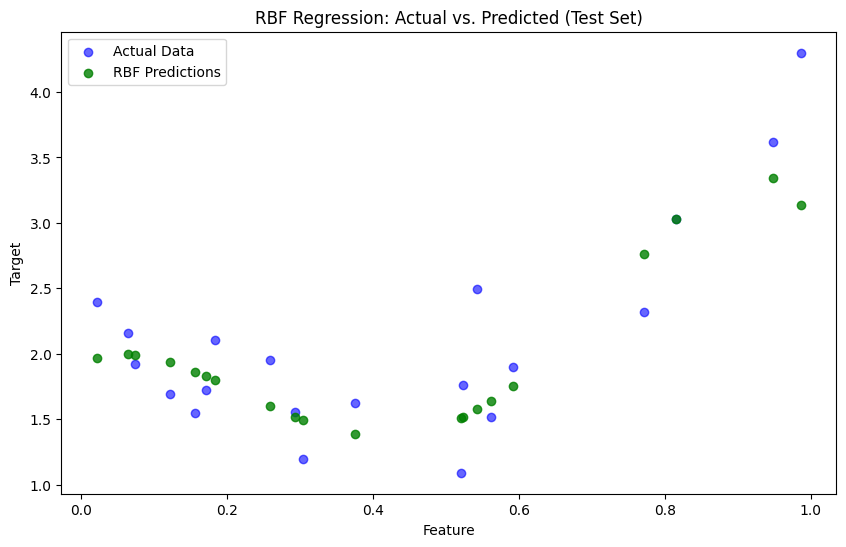

In [130]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge  # Ensure this is properly imported
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load the dataset (example dataset)
np.random.seed(42)
n_samples = 100
X = np.random.rand(n_samples, 1)  # Single feature
y = 5 * X[:, 0]**2 - 3 * X[:, 0] + 2 + np.random.randn(n_samples) * 0.5  # Quadratic relationship with noise

# Step 2: Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Normalize the feature values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RBF Kernel Ridge Regression model
gamma = 2.0  # RBF kernel parameter
alpha = 1e-6  # Regularization strength

# Use KernelRidge from scikit-learn
model = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
model.fit(X_train_scaled, y_train)

# Step 5: Evaluate the Model on Test Set
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"RBF Test MSE: {mse:.4f}")
print(f"RBF Test MAE: {mae:.4f}")
print(f"RBF Test R²: {r2:.4f}")

# Step 6: Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label="Actual Data", color='blue', alpha=0.6)
plt.scatter(X_test, y_test_pred, label="RBF Predictions", color='green', alpha=0.8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("RBF Regression: Actual vs. Predicted (Test Set)")
plt.legend()
plt.show()
